<a href="https://colab.research.google.com/github/ramin40/producing-fake-handwritten-/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# importing necessary libreries

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import time
from keras import layers
import matplotlib.pyplot as plt
from glob import glob
import skimage
from skimage import transform
from skimage import io
from pathlib import Path
import string
import matplotlib.pyplot as plt

# initila values

In [36]:
LATENT_DIM=256
EPOCHS=5
BATCH_SIZE=64
INPUT_SHAPE=(28,28,1)



A GAN training loop looks like this (from tensorflow ducumentation):

1) Train the discriminator.
- Sample a batch of random points in the latent space.
- Turn the points into fake images via the "generator" model.
- Get a batch of real images and combine them with the generated images.
- Train the "discriminator" model to classify generated vs. real images.

2) Train the generator.
- Sample random points in the latent space.
- Turn the points into fake images via the "generator" network.
- Get a batch of real images and combine them with the generated images.
- Train the "generator" model to "fool" the discriminator and classify the fake images
as real.

# building discriminator


In [6]:
Disciminator=keras.Sequential([
  keras.Input(shape=INPUT_SHAPE),
  layers.Conv2D(64,(5,5),strides=(2,2),padding='same'),
  layers.LeakyReLU(alpha=0.2),
  layers.Conv2D(128,(3,3),strides=(2,2),padding='same'),
  layers.LeakyReLU(alpha=0.2),
  layers.GlobalAveragePooling2D(),
  layers.Dense(1)       
],name='discriminator')
Disciminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_6 (ModuleWrap (None, 14, 14, 64)        1664      
_________________________________________________________________
module_wrapper_7 (ModuleWrap (None, 14, 14, 64)        0         
_________________________________________________________________
module_wrapper_8 (ModuleWrap (None, 7, 7, 128)         73856     
_________________________________________________________________
module_wrapper_9 (ModuleWrap (None, 7, 7, 128)         0         
_________________________________________________________________
module_wrapper_10 (ModuleWra (None, 128)               0         
_________________________________________________________________
module_wrapper_11 (ModuleWra (None, 1)                 129       
Total params: 75,649
Trainable params: 75,649
Non-trainable params: 0
_________________________________________________

# building generator


In [17]:
generator = keras.Sequential(
    [
        keras.Input(shape=(LATENT_DIM,)),
        # We want to generate 128 coefficients to reshape into a 7x7x128 map
        layers.Dense(7 * 7 * 128),
        layers.LeakyReLU(alpha=0.2),
        layers.Reshape((7, 7, 128)),
        layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_52 (ModuleWra (None, 6272)              1611904   
_________________________________________________________________
module_wrapper_53 (ModuleWra (None, 6272)              0         
_________________________________________________________________
module_wrapper_54 (ModuleWra (None, 7, 7, 128)         0         
_________________________________________________________________
module_wrapper_55 (ModuleWra (None, 14, 14, 128)       147584    
_________________________________________________________________
module_wrapper_56 (ModuleWra (None, 14, 14, 128)       0         
_________________________________________________________________
module_wrapper_57 (ModuleWra (None, 28, 28, 128)       147584    
_________________________________________________________________
module_wrapper_58 (ModuleWra (None, 28, 28, 128)       0 

In [10]:
d_optimizer=keras.optimizers.Adam(0.0002,decay=1e-06)
g_optimizer=keras.optimizers.Adam(0.0003,decay=1e-06)
loss_fn=keras.losses.BinaryCrossentropy(from_logits=True)

In [18]:
@tf.function
def train_step(real_image):
  #training discriminator
  random_noise=tf.random.normal((BATCH_SIZE,LATENT_DIM))
  fake_images=generator(random_noise)
  concated_images=tf.concat([real_images,fake_images],axis=0)
  real_labels=tf.zeros((real_image.shape[0],1))
  fake_labels=tf.ones((BATCH_SIZE,1))
  labels=tf.concat([real_labels,fake_labels],axis=0)
  # Add random noise to the labels 
  labels += 0.05 * tf.random.uniform(labels.shape)
  #c=zip(concated_images,labels)
  with tf.GradientTape() as tape:

    prediction=Disciminator(concated_images)
    d_loss=loss_fn(labels,prediction)
  grads=tape.gradient(d_loss,Disciminator.trainable_weights)
  d_optimizer.apply_gradients(zip(grads,Disciminator.trainable_weights))
  #reining generator 
  random_noise=tf.random.normal((BATCH_SIZE,LATENT_DIM))
  fooling_labels=tf.zeros((BATCH_SIZE,1))
  with tf.GradientTape() as tape:

    predictions = Disciminator(generator(random_noise))
    g_loss = loss_fn(fooling_labels, predictions)
  grads = tape.gradient(g_loss, generator.trainable_weights)
  g_optimizer.apply_gradients(zip(grads, generator.trainable_weights))
  return d_loss, g_loss, fake_images


In [37]:
#loading data
import os
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
all_digits = np.concatenate([x_train, x_test])

all_digits = np.reshape(all_digits, (-1, 28, 28, 1)).astype(np.float32)/255
dataset = tf.data.Dataset.from_tensor_slices(all_digits)
dataset = dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE)

for epoch in range(EPOCHS):
    print("\nStart epoch", epoch)

    for step, real_images in enumerate(dataset):
        # Train the discriminator & generator on one batch of real images.
        d_loss, g_loss, generated_images = train_step(real_images)

        # Logging.
        if step % 200 == 0:
            # Print metrics
            print("discriminator loss at step %d: %.2f" % (step, d_loss))
            print("adversarial loss at step %d: %.2f" % (step, g_loss))

            '''# Save one generated image
            img = tf.keras.preprocessing.image.array_to_img(
                generated_images[0] * 255.0, scale=False
            )
            plt.imshow(img)
            plt.show()
            img.save(os.path.join(save_dir, "generated_img" + str(step) + ".png"))

        # To limit execution time we stop after 10 steps.
        # Remove the lines below to actually train the model!
        if step > 10:
            break'''


Start epoch 0
discriminator loss at step 0: 0.58
adversarial loss at step 0: 0.88
discriminator loss at step 200: 0.59
adversarial loss at step 200: 0.97
discriminator loss at step 400: 0.57
adversarial loss at step 400: 0.92
discriminator loss at step 600: 0.57
adversarial loss at step 600: 0.78
discriminator loss at step 800: 0.58
adversarial loss at step 800: 0.91
discriminator loss at step 1000: 0.59
adversarial loss at step 1000: 0.92

Start epoch 1
discriminator loss at step 0: 0.59
adversarial loss at step 0: 0.77
discriminator loss at step 200: 0.57
adversarial loss at step 200: 0.82
discriminator loss at step 400: 0.58
adversarial loss at step 400: 0.89
discriminator loss at step 600: 0.57
adversarial loss at step 600: 0.92
discriminator loss at step 800: 0.57
adversarial loss at step 800: 0.88
discriminator loss at step 1000: 0.57
adversarial loss at step 1000: 0.94

Start epoch 2
discriminator loss at step 0: 0.60
adversarial loss at step 0: 0.73
discriminator loss at step 

# generated fake images

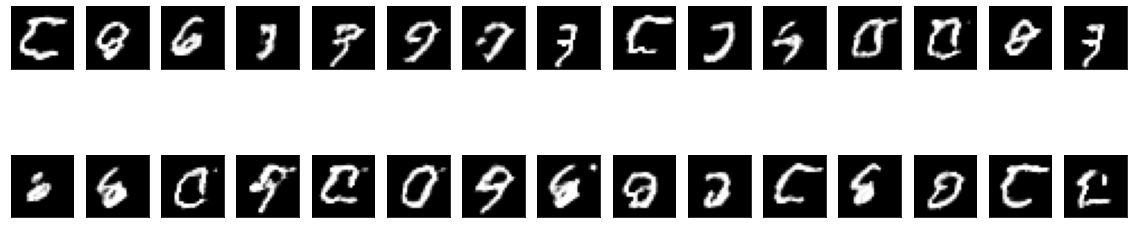

In [38]:
fig=plt.figure(figsize=(20,5))
for i,img in enumerate(generated_images[0:30]):
  ax=fig.add_subplot(2,15,i+1,xticks=[],yticks=[])
  ax.imshow(np.squeeze(img),cmap='gray')
